In [1]:
%matplotlib  inline
import pandas as pd
from datetime import datetime
import quandl
import numpy as np
import matplotlib.pyplot as plt
import sklearn.preprocessing as prep
import sklearn.model_selection as ms
import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
from scipy import poly1d
from pykalman import KalmanFilter

In [135]:
# All helper functions go here
def supres(ltp, n):
    """
    This function takes a numpy array of last traded price
    and returns a list of support and resistance levels 
    respectively. n is the number of entries to be scanned.
    """
    from scipy.signal import savgol_filter as smooth

    #converting n to a nearest even number
    if n%2 != 0:
        n += 1
    ltp=np.ravel(ltp)
    n_ltp = ltp.shape[0]

    # smoothening the curve
    ltp_s = smooth(ltp, (n+1), 3) 

    #taking a simple derivative
    ltp_d = np.zeros(n_ltp)
    ltp_d[1:] = np.subtract(ltp_s[1:], ltp_s[:-1])
 
    resistance = []
    support = []
    
    for i in range(n_ltp - n):
        arr_sl = ltp_d[i:(i+n)]
        first = arr_sl[:int((n/2))] #first half
        last = arr_sl[int((n/2)):] #second half
        
        r_1 = np.sum(first > 0)
        r_2 = np.sum(last < 0)

        s_1 = np.sum(first < 0)
        s_2 = np.sum(last > 0)

        #local maxima detection
        if (r_1 == int((n/2))) and (r_2 == int((n/2))): 
            resistance.append(ltp[i+int(((n/2))-1)])

        #local minima detection
        if (s_1 == int((n/2))) and (s_2 == int((n/2))): 
            support.append(ltp[i+int(((n/2))-1)])

    return support, resistance
import scipy.ndimage as ndimage

def local_extreme(array, min_distance = 20, periodic=False, edges_allowed=True,find_max=True): 
    """Find all local maxima of the array, separated by at least min_distance."""
    array = np.asarray(array)
    cval = 0 
    if periodic: 
        mode = 'wrap' 
    elif edges_allowed: 
        mode = 'nearest' 
    else: 
        mode = 'constant' 
    cval = array.max()+1 
    if find_max:
        max_points = array == ndimage.maximum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
    else:
        max_points = array == ndimage.minimum_filter(array, 1+2*min_distance, mode=mode, cval=cval) 
        
    return [indices[max_points] for indices in np.indices(array.shape)]

def extreme_significance(exArray, tolerance=0.02,signi_level=1):
    """Find Significance of extreme values within tolerance bound."""
    array = np.asarray(exArray)
    array = np.ravel(array)
    signifArr = np.zeros(len(array))
    d = {'data': array, 'sign': signifArr}
    result = pd.DataFrame(data=d).values
    print('len of x is: '+repr(len(result)))
    for i in range(len(result)):
        val = result[i,0]
        signif = 0
        for j in range(i+1,len(result)):
            if (result[j,0]>= val*(1-tolerance)) and  (array[j]<= val*(1+tolerance)):
                    signif = signif + 1
            result[i,1] = signif
            
    result = pd.DataFrame(data=result,columns=['ExtremeValue', 'Significance'])
    result = result[result.Significance>=signi_level]
    return result.sort_values(by=['Significance'],ascending=False)

def grouper(iterable, max_distance):
    """Group extremes by cluster based on absolute price distance."""
    # if Dataframe take first column
    if isinstance(signify,pd.core.frame.DataFrame):
        iterable = iterable.sort_values(by=iterable.columns[0]).iloc[:,0].values
    elif isinstance(signify,np.ndarray):
        iterable =np.sort(iterable)
    prev = None
    group = []
    for item in iterable:
        if not prev or item - prev <= max_distance:
            group.append(item)
        else:
            yield group
            group = [item]
        prev = item
    if group:
        yield group
def group_extremes(inp,max_distance):
    """Calculate centroid for each cluster of prices"""
    inp = dict(enumerate(grouper(inp,max_distance), 1))
    avgDict = {}
    for k,v in inp.items():
        # v is the list of items for dict row k
        avgDict[k] = sum(v)/ float(len(v))
    return list(avgDict.values())

def logReturns(df):
    """Calculate logReturns of price series"""
    log_ret = np.log(df) - np.log(df.shift(1))
    return log_ret

def tsi(close, r=25, s=13, fillna=True):
    """Calculate TSI Indicator of close price series"""
    m = close - close.shift(1)
    m1 = m.ewm(r).mean().ewm(s).mean()
    m2 = abs(m).ewm(r).mean().ewm(s).mean()
    tsi = m1/m2
    if fillna:
        tsi = tsi.fillna(0)
    return pd.Series(100*tsi, name='tsi')

def on_balance_volume(close, volume):
    """Calculate OBV Indicator of close price series and Volume"""
    df = pd.DataFrame([close, volume]).transpose()
    df['OBV'] = 0
    c1 = close < close.shift(1)
    c2 = close > close.shift(1)
    if c1.any():
        df.loc[c1, 'OBV'] = - volume
    if c2.any():
        df.loc[c2, 'OBV'] = volume
    return df['OBV']

def average_true_range(high, low, close, n=14, fillna=False):
    """Average True Range (ATR)
    The indicator provide an indication of the degree of price volatility.
    Strong moves, in either direction, are often accompanied by large ranges,
    or large True Ranges.
    http://stockcharts.com/school/doku.php?id=chart_school:technical_indicators:average_true_range_atr
    Args:
        high(pandas.Series): dataset 'High' column.
        low(pandas.Series): dataset 'Low' column.
        close(pandas.Series): dataset 'Close' column.
        n(int): n period.
    Returns:
        pandas.Series: New feature generated.
    """
    cs = close.shift(1)
    tr = high.combine(cs, max) - low.combine(cs, min)
    tr = tr.ewm(n).mean()
    if fillna:
        tr = tr.fillna(0)
    return pd.Series(tr, name='atr')

def kst(close, r1=10, r2=15, r3=20, r4=30, n1=10, n2=10, n3=10, n4=15, nsig=9, fillna=True):
    """Calculate KST Indicator of close price series. See https://en.wikipedia.org/wiki/KST_oscillator"""
    rocma1 = (close / close.shift(r1) - 1).rolling(n1).mean()
    rocma2 = (close / close.shift(r2) - 1).rolling(n2).mean()
    rocma3 = (close / close.shift(r3) - 1).rolling(n3).mean()
    rocma4 = (close / close.shift(r4) - 1).rolling(n4).mean()
    kst = 100*(rocma1 + 2*rocma2 + 3*rocma3 + 4*rocma4)
    sig = kst.rolling(nsig).mean()
    if fillna:
        sig = sig.fillna(0)
    return pd.Series(sig, name='sig')

def find_nearest(array, value,findMax=True):
    """Find nearest value of extreme value"""
    array = np.sort(np.asarray(array))
    if findMax:
        array = array[array>=value]
    else:
        array = array[array<=value]
    if array.size > 0:
        idx = (np.abs(array - value)).argmin()
        return array[idx]
    else:
        return np.nan
    
def calc_extreme_distance(series,sup_array,res_array):
    if isinstance(series,pd.core.frame.DataFrame):
        series = np.ravel(series.values())
    elif isinstance(series,np.ndarray):
        series =np.ravel(series)
    sup_array = np.ravel(np.array(sup_array))
    res_array = np.ravel(np.array(res_array))
    dist_s = []
    dist_r = []
    #if not sup_array:
    #    print("test")
    #else:
    for i in range(len(series)):
        curr_value = series[i]
        nearest_sup = find_nearest(sup_array, curr_value,findMax=False)
        nearest_res = find_nearest(res_array, curr_value)
        if curr_value < nearest_sup:
            dist_s.append(np.nan)
        elif curr_value > nearest_res:
            dist_r.append(np.nan)
        else:
            dist_s.append(curr_value-nearest_sup)
            dist_r.append(nearest_res-curr_value)
    if dist_s and dist_r:
        return dist_s,dist_r
    


In [3]:
quandl.ApiConfig.api_key = "xoemPs9s3Dtwf3aQxQ-3"
start="2010-01-02"

INTC = pdr.get_data_yahoo("INTC",start=start)
MSFT = pdr.get_data_yahoo("MSFT",start=start)
AMZN = pdr.get_data_yahoo("AMZN",start=start)
NVDA = pdr.get_data_yahoo("NVDA",start=start)
GOOG = pdr.get_data_yahoo("GOOG",start=start)
NFLX = pdr.get_data_yahoo("NFLX",start=start)
FB = pdr.get_data_yahoo("FB",start=start)
# macro data 
EUROSTOXX50 = pdr.get_data_yahoo("FEZ",start=start)
SNP500 = pdr.get_data_yahoo("^GSPC",start=start)
CONS_DESCRETE = pdr.get_data_yahoo("XLY",start=start)
SNP_TECH = pdr.get_data_yahoo("XLK",start=start)
NASDAQ_COMP = pdr.get_data_yahoo("^IXIC",start=start)
VIX = pdr.get_data_yahoo("^VIX",start=start)

# FRED & Treasury
yieldr = quandl.get("USTREASURY/REALYIELD", start_date=start, verify=False)
consumer_price_index = quandl.get("FRED/CPIAUCSL", start_date=start, verify=False)
gdpc = quandl.get("FRED/GDPC1", start_date=start, verify=False)
tnote_y10 = quandl.get("FRED/DGS10", start_date=start, verify=False)
financial_stress = quandl.get("FRED/STLFSI", start_date=start, verify=False)
effective_federal_fund_rate = quandl.get("FRED/FEDFUNDS", start_date=start, verify=False)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


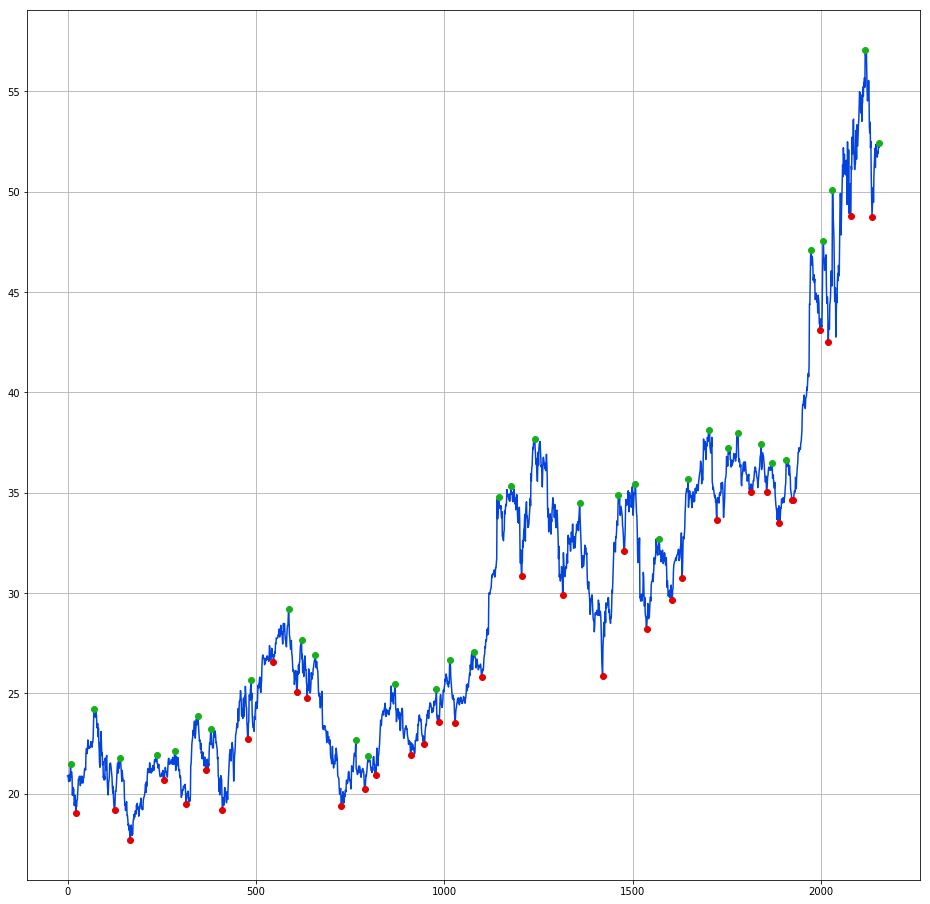

In [4]:
# Plots
cl=np.ravel(INTC[['Close']].values)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
mDistance = 20
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=True)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=True)]) ,color='xkcd:green',marker='o',linestyle ='')
plt.plot(np.ravel(local_extreme(cl,min_distance= mDistance,find_max=False)),
         np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=False)]) ,color='xkcd:red',marker='o',linestyle ='')
plt.grid(True)

len of x is: 36


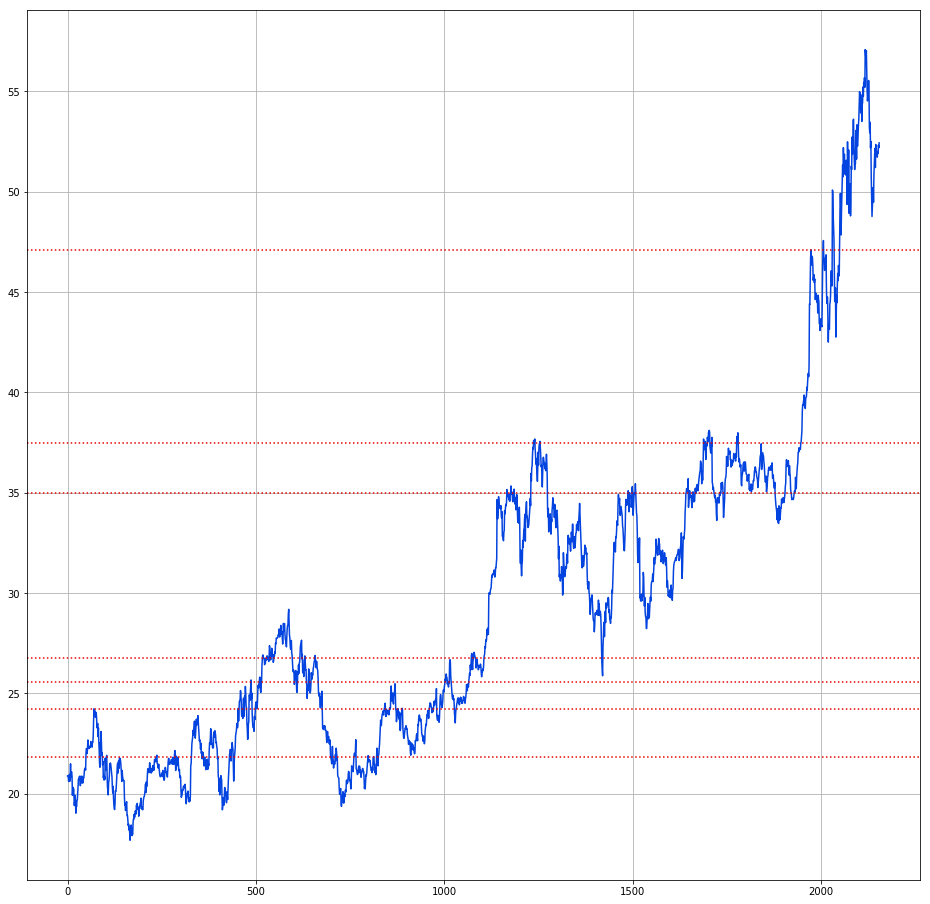

In [5]:
# Show horizontal resistance levels based on extreme points and significance
array = np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=True)])
signify = extreme_significance(array, tolerance=0.02,signi_level=1)
extremes_res = group_extremes(signify,1)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_res)
for x in yval:
    plt.axhline(y=x,color='xkcd:red',linestyle =':')
plt.grid(True)

len of x is: 36


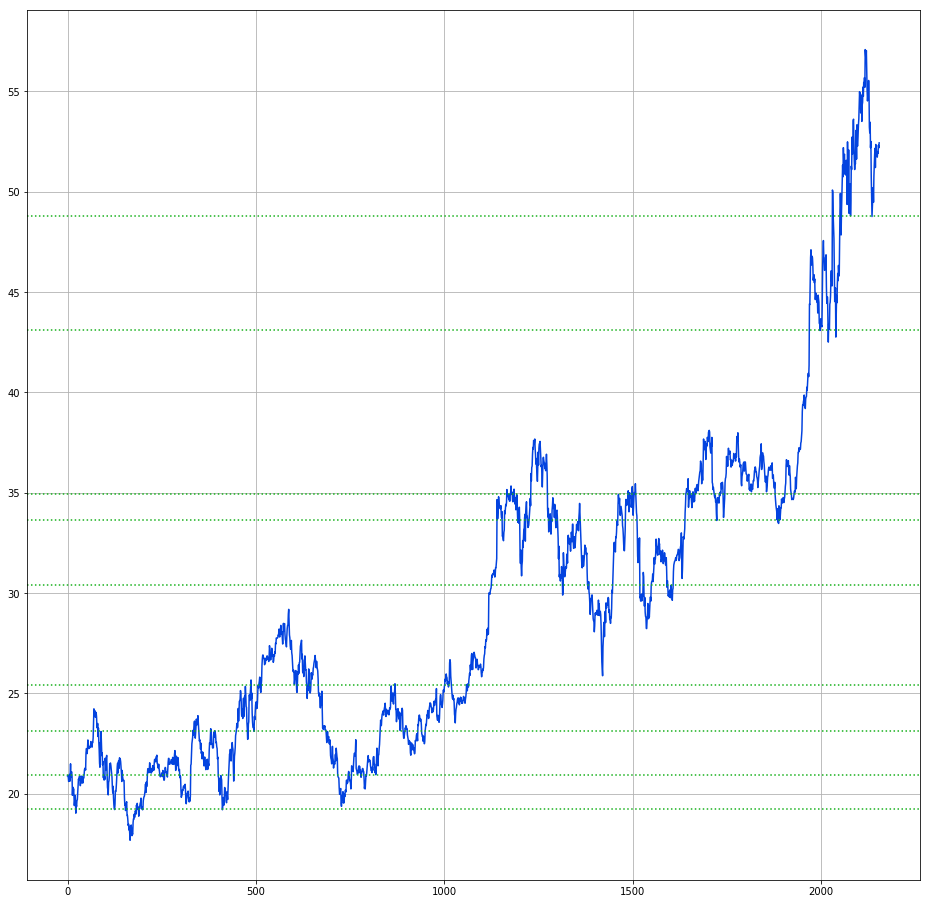

In [6]:
# Show horizontal support levels based on extreme points and significance
array = np.ravel(cl[local_extreme(cl,min_distance= mDistance,find_max=False)])
signify =extreme_significance(array, tolerance=0.02,signi_level=1)
extremes_sup = group_extremes(signify,1)
plt.rc("figure",figsize=(16,16))
plt.plot(cl,color='xkcd:blue',linestyle ='-')
yval = np.ravel(extremes_sup)
for x in yval:
    plt.axhline(y=x,color='xkcd:green',linestyle =':')
plt.grid(True)

In [111]:
result = pd.concat([INTC, MSFT[['Close']].rename(columns={'Close': 'MSFT'})], axis=1)
result = pd.concat([result, AMZN[['Close']].rename(columns={'Close': 'AMZN'})], axis=1)
result = pd.concat([result, NVDA[['Close']].rename(columns={'Close': 'NVDA'})], axis=1)
result = pd.concat([result, GOOG[['Close']].rename(columns={'Close': 'GOOG'})], axis=1)
result = pd.concat([result, NFLX[['Close']].rename(columns={'Close': 'NFLX'})], axis=1)
result = pd.concat([result, FB[['Close']].rename(columns={'Close': 'FB'})], axis=1)
result = pd.concat([result, EUROSTOXX50[['Close']].rename(columns={'Close': 'EUROSTOXX50'})], axis=1)
result = pd.concat([result, SNP500[['Close']].rename(columns={'Close': 'SNP500'})], axis=1)
result = pd.concat([result, CONS_DESCRETE[['Close']].rename(columns={'Close': 'CONS_DESCRETE'})], axis=1)
result = pd.concat([result, SNP_TECH[['Close']].rename(columns={'Close': 'SNP_TECH'})], axis=1)
result = pd.concat([result, NASDAQ_COMP[['Close']].rename(columns={'Close': 'NASDAQ_COMP'})], axis=1)
result = pd.concat([result, VIX[['Close']].rename(columns={'Close': 'VIX'})], axis=1)

# distance to next extremes
[sup,res] = calc_extreme_distance(cl,extremes_sup,extremes_res) 
sr = pd.DataFrame(data=np.transpose([sup,res]),index=INTC.index )
sr.columns = ['support_distance', 'resistance_distance']
result = pd.concat([result, sr], axis=1)

# fred
result = pd.concat([result, yieldr[['5 YR']].rename(columns={'5 YR': 'yield_5y'})], axis=1)
result = pd.concat([result, tnote_y10.rename(columns={'Value': 'Tnote_10y'})], axis=1)

result = result.drop('Adj Close', axis=1)
result['Weekday'] = result.index.weekday
result['Daymonth'] = result.index.day
result['Month'] = result.index.month
result['Weakyear'] = result.index.weekofyear

#result = result.dropna()

In [112]:
result[['yield_5y']] = result[['yield_5y']].replace(0, 0.00000001)
result[['yield_5y']] = result[['yield_5y']]+10
result[['support_distance']] = result[['support_distance']].replace(0, 0.00000001)
result[['resistance_distance']] = result[['resistance_distance']].replace(0, 0.00000001)
logRet = result[['High','Low','Close','MSFT','AMZN','NVDA','GOOG','NFLX','FB','EUROSTOXX50','SNP500',
                 'CONS_DESCRETE','SNP_TECH','NASDAQ_COMP','VIX','yield_5y','Tnote_10y']].apply(logReturns)

logRet.columns = [str(col) + '_logReturns' for col in logRet.columns]

result = pd.concat([result, logRet], axis=1)
scaler = prep.MaxAbsScaler().fit(result[['Volume']].values)
result['Volume_Scaled'] = scaler.transform(result[['Volume']].values)

result.head(3)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [113]:
momentum  =  result[['Close']].diff(periods=5)
momentum  =  momentum[~np.isnan(momentum)]
result['TradingRange'] = result["High"]-result["Low"]
result['OBV'] = on_balance_volume(result["Close"], result["Volume"])
result['TSI'] = tsi(result["Close"])
result['ATR'] = average_true_range(result["High"],result["Low"],result["Close"])
result['HighestHigh'] = result['High'].rolling(window=21,center=False,min_periods=1).max()
result['LowestLow'] = result['Low'].rolling(window=21,center=False,min_periods=1).min()

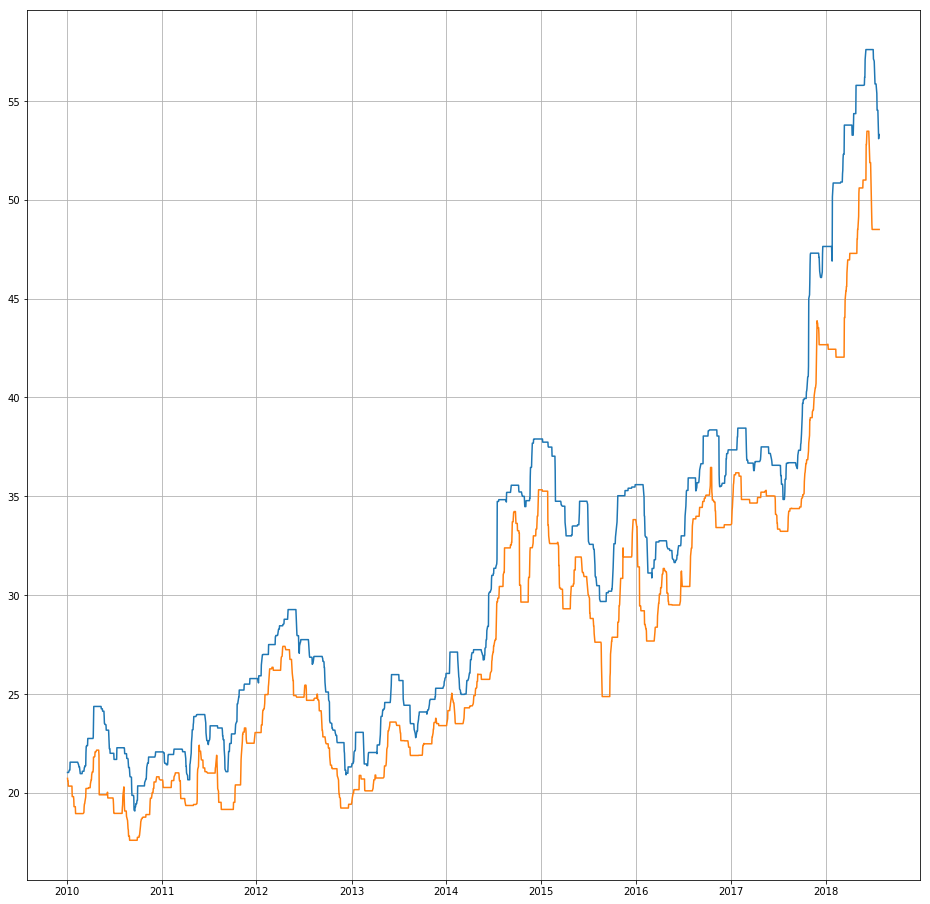

In [114]:
from matplotlib.pyplot import figure
plt.rc("figure",figsize=(16,16))
plt.plot(result['HighestHigh'])
plt.plot(result['LowestLow'])
plt.grid(True)

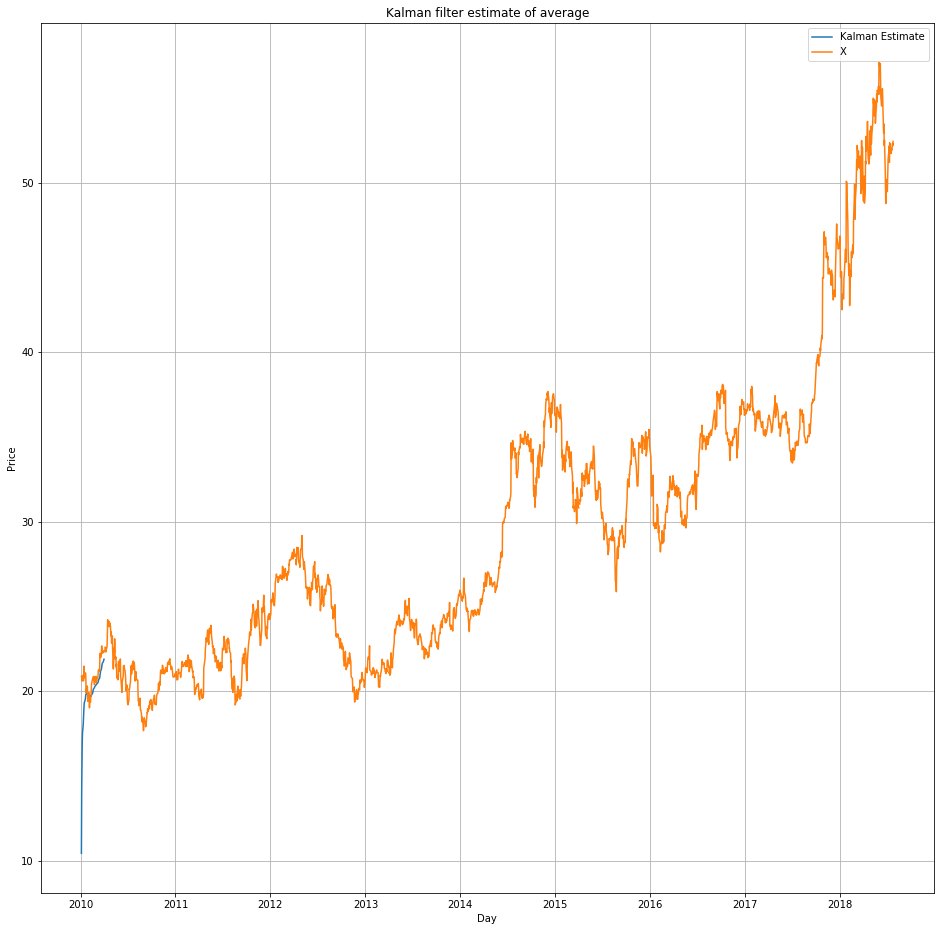

In [115]:
x = (result[['Close']])
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)
state_means, _ = kf.filter(x.values)
state_means = pd.Series(state_means.flatten(), index=x.index)

plt.rc("figure",figsize=(16,16))
# Plot original data and estimated mean
plt.plot(state_means)
plt.plot(x)
plt.title('Kalman filter estimate of average')
plt.legend(['Kalman Estimate', 'X'])
plt.xlabel('Day')
plt.ylabel('Price');
plt.grid(True)

In [116]:
scaler = prep.MaxAbsScaler().fit(result[['ATR']].values)
result['ATR_Scaled'] = scaler.transform(result[['ATR']].values)

scaler = prep.MaxAbsScaler().fit(result[['TSI']].values)
result['TSI_Scaled'] = scaler.transform(result[['TSI']].values)

scaler = prep.MaxAbsScaler().fit(result[['OBV']].values)
result['OBV_Scaled'] = scaler.transform(result[['OBV']].values)

scaler = prep.MaxAbsScaler().fit(result[['TradingRange']].values)
result['TradingRange_Scaled'] = scaler.transform(result[['TradingRange']].values)

scaler = prep.MaxAbsScaler().fit(result[['HighestHigh']].values)
result['HighestHigh_Scaled'] = scaler.transform(result[['HighestHigh']].values)

scaler = prep.MaxAbsScaler().fit(result[['LowestLow']].values)
result['LowestLow_Scaled'] = scaler.transform(result[['LowestLow']].values)

scaler = prep.MaxAbsScaler().fit(state_means.to_frame().values)
result['KFMean_Scaled'] = scaler.transform(state_means.to_frame().values)
result = result.iloc[5:]

scaler = prep.MaxAbsScaler().fit(result[['support_distance']].values)
result['support_distance_Scaled'] = scaler.transform(result[['support_distance']].values)

scaler = prep.MaxAbsScaler().fit(result[['resistance_distance']].values)
scaler = prep.MaxAbsScaler().fit(result[['resistance_distance']].values)
result['resistance_distance_Scaled'] = scaler.transform(result[['resistance_distance']].values)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
result['TSI_Scaled'] =  result['TSI_Scaled'].replace(-1,0)
result = result.drop('TSI', axis=1)
result = result.drop('ATR', axis=1)
result = result.drop('OBV', axis=1)
result = result.drop('TradingRange', axis=1)
result = result.drop('HighestHigh', axis=1)
result = result.drop('LowestLow', axis=1)
# delete 0 values
result = result[result.TSI_Scaled != 0]

In [ ]:
train_data = result.drop(['Open', 'High','Low','Close','Volume','MSFT','AMZN','NVDA','GOOG','NFLX','FB'
                          ,'EUROSTOXX50','SNP500','CONS_DESCRETE','SNP_TECH','NASDAQ_COMP','yield_5y'
                          ,'Tnote_10y','support_distance','resistance_distance'], axis=1)

In [ ]:
pd.set_option('display.max_columns', 100)
train_data.head(11)

In [ ]:
# Plot intel log returns to other 
plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:black',linestyle ='-')
plt.plot(np.cumsum(train_data[['MSFT_logReturns']]),linestyle ='-')
plt.plot(np.cumsum(train_data[['AMZN_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['GOOG_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['NVDA_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['NFLX_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['FB_logReturns']]),color='xkcd:cyan',linestyle =':')
plt.legend(['INTC','MSFT','AMZN','GOOG','NVDA','NFLX','FB'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
df_corr = train_data[['Close_logReturns','MSFT_logReturns','AMZN_logReturns','GOOG_logReturns','NVDA_logReturns',
                       'NFLX_logReturns','FB_logReturns']]

In [ ]:
df = df_corr.corr()
import matplotlib.cm as cm
size = 7
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(df,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(df.columns)), df.columns, fontsize=8);
df

In [ ]:
from matplotlib.pyplot import figure
plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:red',linestyle ='-')
plt.plot(np.cumsum(train_data[['MSFT_logReturns']]),color='xkcd:cyan',linestyle ='-')
plt.grid(True,which ='both')
plt.legend(['INTC','MSFT'], loc='upper left')

In [ ]:
# Plot intel log returns to macro
from matplotlib.pyplot import figure
plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:black',linestyle ='-')
plt.plot(np.cumsum(train_data[['EUROSTOXX50_logReturns']]),linestyle ='-')
plt.plot(np.cumsum(train_data[['yield_5y_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['Tnote_10y_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['NASDAQ_COMP_logReturns']]),linestyle ='-')
plt.plot(np.cumsum(train_data[['SNP500_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['SNP_TECH_logReturns']]),color='xkcd:cyan',linestyle =':')
plt.plot(np.cumsum(train_data[['CONS_DESCRETE_logReturns']]),linestyle =':')
plt.plot(np.cumsum(train_data[['VIX_logReturns']]),linestyle =':')
plt.legend(['INTC','EUROSTOXX','yield5y','Tnote','NASDAQ','S&P500','S&P_Tech','CONSUMER DESCRETE','VIX'], loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
df_corr2 = train_data[['Close_logReturns','EUROSTOXX50_logReturns','yield_5y_logReturns','Tnote_10y_logReturns','NASDAQ_COMP_logReturns',
                       'SNP500_logReturns','SNP_TECH_logReturns','CONS_DESCRETE_logReturns','VIX_logReturns']]

In [ ]:
df = df_corr2.corr()
import matplotlib.cm as cm
size = 7
fig, ax = plt.subplots(figsize=(size, size))
ax.matshow(df,cmap=cm.get_cmap('coolwarm'), vmin=0,vmax=1)
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical', fontsize=8);
plt.yticks(range(len(df.columns)), df.columns, fontsize=8);
df

In [ ]:
from matplotlib.pyplot import figure
plt.rc("figure",figsize=(16,16))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:red',linestyle ='-')
plt.plot(np.cumsum(train_data[['SNP_TECH_logReturns']]),color='xkcd:cyan',linestyle ='-')
plt.plot(np.cumsum(train_data[['NASDAQ_COMP_logReturns']]),color='xkcd:green',linestyle ='-')
plt.grid(True,which ='both')
plt.legend(['INTC','SNP_TECH_logReturns','NASDAQ_COMP_logReturns'], loc='upper left')

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 10))
plt.plot(np.cumsum(train_data[['Close_logReturns']]), color='xkcd:red',linestyle ='-')
plt.plot(np.cumsum(train_data[['VIX_logReturns']]),color='xkcd:blue',linestyle ='-')
plt.grid(True,which ='both')
plt.legend(['INTC','VIX'], loc='upper left')

In [ ]:
# show lagged cross correlation between intc and highest corr coeff
import matplotlib.pyplot as plt
intc_arr = np.array((df_corr2[['Close_logReturns']]))
snptech_arr = np.array((df_corr2[['SNP_TECH_logReturns']]))
intc_arr = intc_arr.ravel()
snptech_arr = snptech_arr.ravel()
plt.rc("figure",figsize=(16,16))
plt.xcorr(intc_arr,snptech_arr,maxlags=50, usevlines=1)
plt.grid(True)
plt.legend(['INTC','SNP_TECH_logReturns'], loc='upper left')
plt.show()

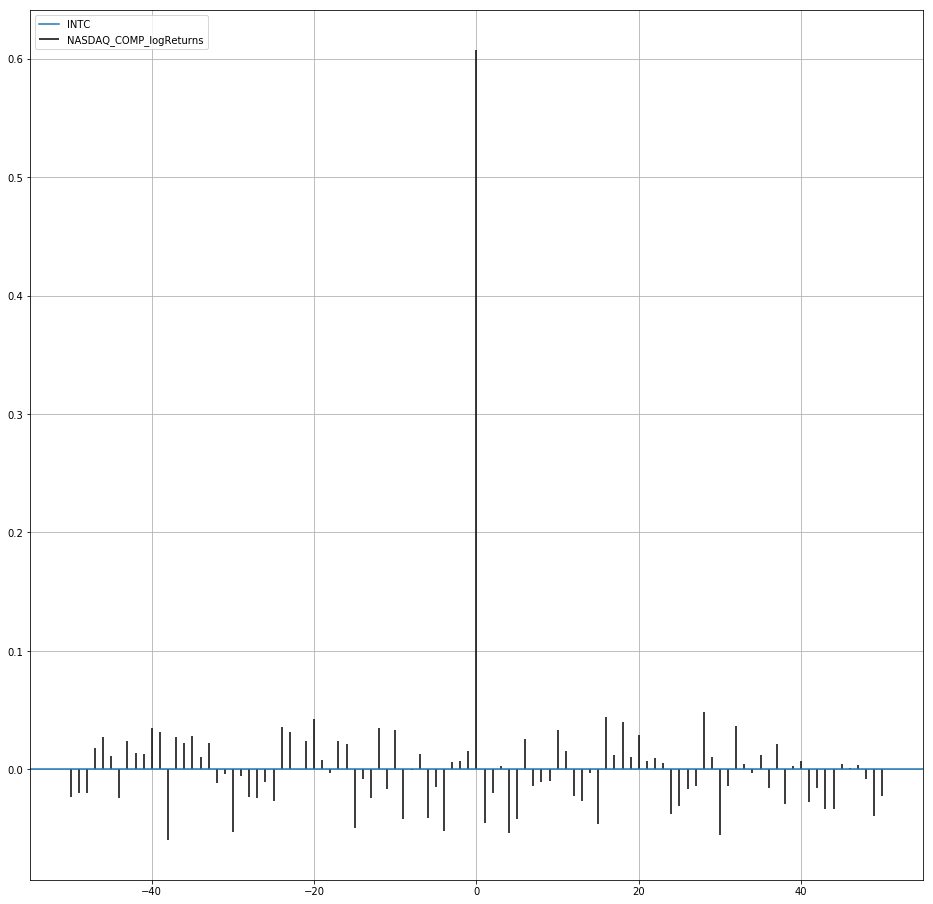

In [117]:
# show lagged cross correlation with NASDAQ_COMP
import matplotlib.pyplot as plt
intc_arr = np.array((df_corr2[['Close_logReturns']]))
snptech_arr = np.array((df_corr2[['NASDAQ_COMP_logReturns']]))
intc_arr = intc_arr.ravel()
snptech_arr = snptech_arr.ravel()
plt.rc("figure",figsize=(16,16))
plt.xcorr(intc_arr,snptech_arr,maxlags=50, usevlines=1)
plt.grid(True)
plt.legend(['INTC','NASDAQ_COMP_logReturns'], loc='upper left')
plt.show()

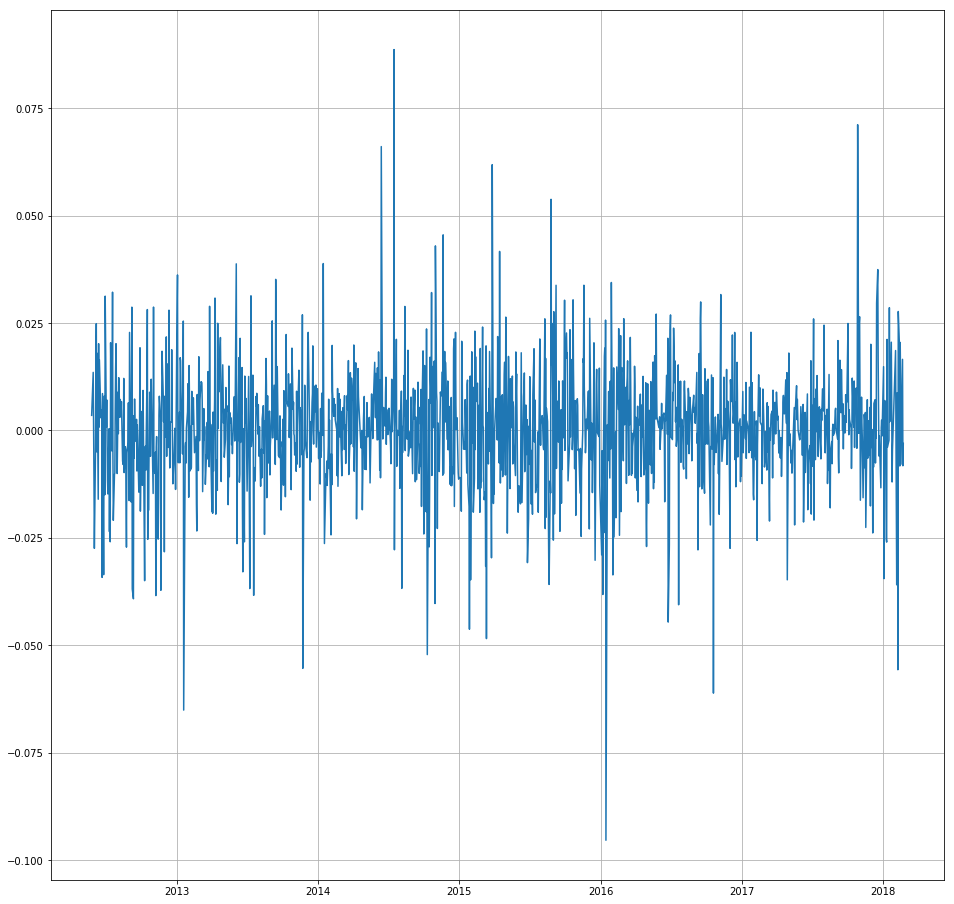

In [118]:
# Show distribution of log returns of INTC
plt.rc("figure",figsize=(16,16))
plt.plot(train_data[['Close_logReturns']])
plt.grid(True)

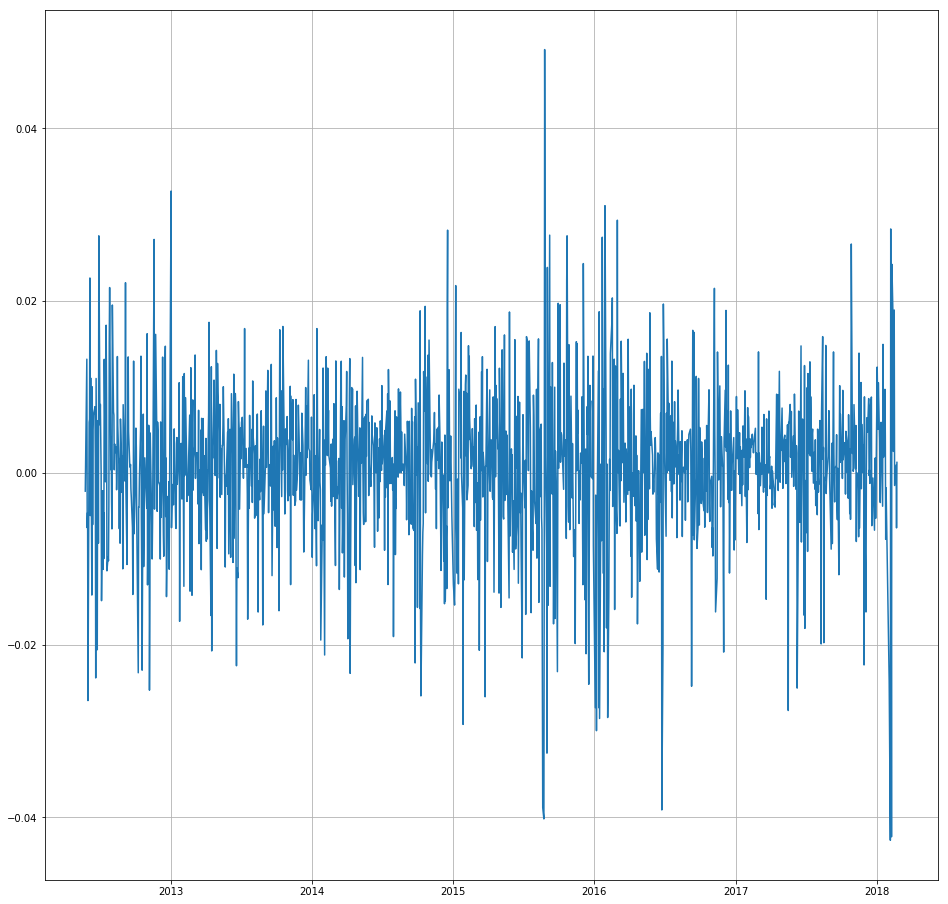

In [119]:
# Show distribution of log returns of SNP Tech
plt.rc("figure",figsize=(16,16))
plt.plot(train_data[['SNP_TECH_logReturns']])
plt.grid(True)

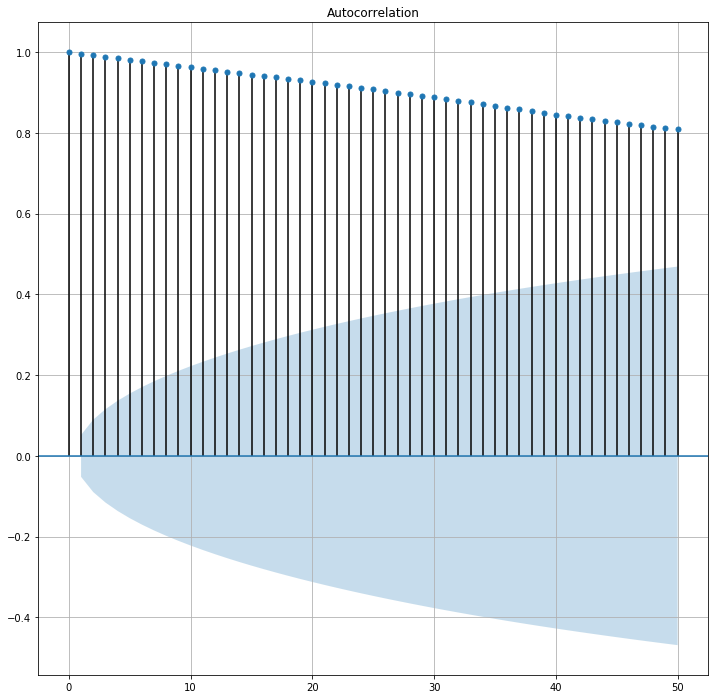

In [120]:
# plot auto correlation with itself
from statsmodels.graphics.tsaplots import plot_acf
intc_arr = np.array(np.cumsum(train_data[['Close_logReturns']]))
intc_arr = intc_arr.ravel()
series = intc_arr
plt.rc("figure",figsize=(12,12))
plot_acf(series, lags=50,use_vlines=True)
plt.grid(True)

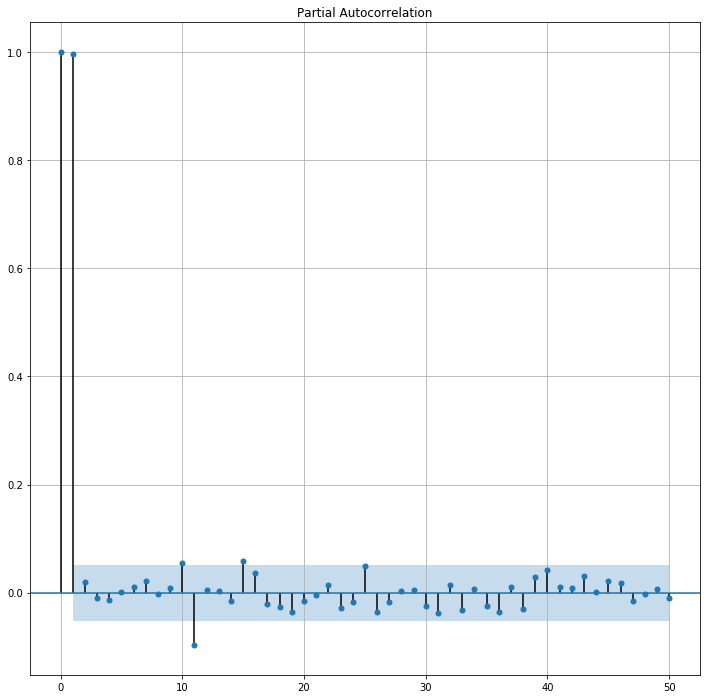

In [121]:
# plot partial auto correlation of INTC
from statsmodels.graphics.tsaplots import plot_pacf
plt.rc("figure",figsize=(12,12))
plot_pacf(series, lags=50,use_vlines=True)
plt.grid(True)

In [122]:
# clip data and cut extremes
train_data['Close_logReturnsClipped'] = train_data['Close_logReturns'].clip(-0.05,0.05)

In [123]:
train_data_final = train_data.drop(['High_logReturns','Low_logReturns','Close_logReturns','AMZN_logReturns','NVDA_logReturns',
                             'GOOG_logReturns','NFLX_logReturns','FB_logReturns','EUROSTOXX50_logReturns',
                             'SNP500_logReturns','CONS_DESCRETE_logReturns','yield_5y_logReturns','Tnote_10y_logReturns','VIX'
                             ], axis=1)

In [124]:
y =  train_data_final['Close_logReturnsClipped']
train_data_final = train_data_final.drop(['Close_logReturnsClipped'], axis=1)

In [127]:
train_data_final.head(11)

,Weekday,Daymonth,Month,Weakyear,MSFT_logReturns,SNP_TECH_logReturns,NASDAQ_COMP_logReturns,VIX_logReturns,Volume_Scaled,ATR_Scaled,TSI_Scaled,OBV_Scaled,TradingRange_Scaled,HighestHigh_Scaled,LowestLow_Scaled,KFMean_Scaled,support_distance_Scaled,resistance_distance_Scaled
Date,,,,,,,,,,,,,,,,,,
2012-05-25,4,25,5,21,-0.000344,-0.002151,-0.000652,0.010162,0.133014,0.384399,-0.371630,0.133014,0.088889,0.555974,0.567912,0.492853,0.039541,0.108264
2012-05-29,1,29,5,22,0.017059,0.013189,0.011723,-0.034123,0.243828,0.386787,-0.269809,0.243828,0.146031,0.555974,0.567912,0.504700,0.084184,0.071653
2012-05-30,2,30,5,22,-0.007470,-0.006394,-0.011783,0.137920,0.230173,0.368071,-0.205559,0.230173,0.123810,0.555974,0.567912,0.514178,0.089286,0.067469
2012-05-31,3,31,5,22,-0.005126,-0.004644,-0.003538,-0.003320,0.293824,0.357562,-0.190969,-0.293824,0.117460,0.555974,0.567912,0.521066,0.052296,0.097803
2012-06-01,4,1,6,22,-0.025678,-0.026484,-0.028652,0.102614,0.279955,0.375841,-0.231291,-0.279955,0.187301,0.555974,0.567912,0.524931,0.257015,0.044456
2012-06-04,0,4,6,23,0.003509,0.005865,0.004550,-0.020463,0.277571,0.373471,-0.262854,-0.277571,0.165080,0.555974,0.566089,0.527938,0.244260,0.054916
2012-06-05,1,5,6,23,-0.001402,0.006194,0.006537,-0.056708,0.205142,0.375577,-0.254254,0.205142,0.180952,0.555974,0.566089,0.531463,0.294005,0.014121
2012-06-06,2,6,6,23,0.029038,0.022626,0.023694,-0.107704,0.233399,0.385843,-0.206797,0.233399,0.215873,0.555974,0.566089,0.536031,0.081633,0.073745
2012-06-07,3,7,6,23,-0.004097,-0.004984,-0.004828,-0.020055,0.205440,0.384209,-0.177952,-0.205440,0.171429,0.555974,0.566089,0.539710,0.065051,0.087343


In [128]:
# Check na
train_data_final.isnull().values.any()

False

In [139]:
X_train, X_test, y_train, y_test = ms.train_test_split(train_data_final, y, test_size=0.33)
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.cross_validation import *

# Fit estimators
model_et  = ExtraTreesRegressor(n_estimators=10, max_features=30,max_depth=None,
                                       random_state=0),

model_et.fit(X_train, y_train)

print ("Coefficient of determination on training set:",model_et.score(X_train, y_train))
cv = KFold(X_train.shape[0], 5, shuffle=True, random_state=33)
scores = cross_val_score(model_et, X_train, y_train, cv=cv)
print ("Average coefficient of determination using 5-fold crossvalidation:",np.mean(scores))
    
predicted_values = regression_task.predict(X_test)
actual_and_test = np.column_stack([y_test, predicted_values])




AttributeError: 'tuple' object has no attribute 'fit'